<a href="https://colab.research.google.com/github/Swaggerlish/Hacknation_project/blob/main/Alpha_Earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 37.0 MB/s eta 0:00:00
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


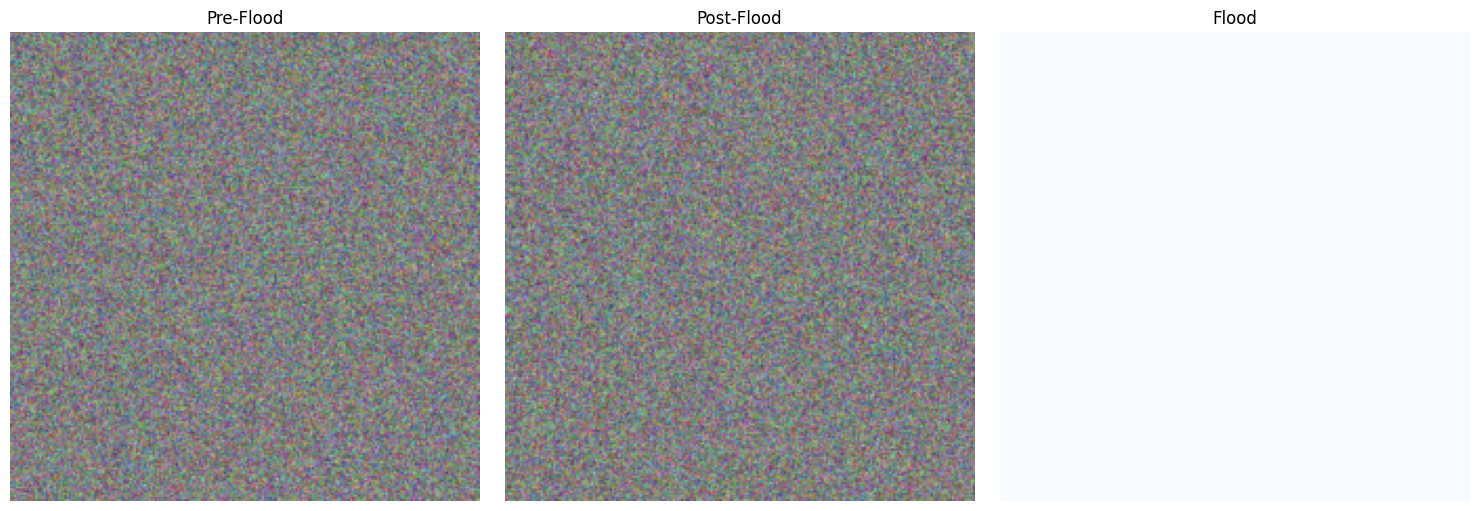

CLAIM RESULT:
{
  "location": {
    "lat": 29.7604,
    "lon": -95.3698
  },
  "event": "Hurricane Harvey",
  "flood_coverage_percent": 0.0,
  "risk_score": 40.0,
  "decision": "Review"
}


In [1]:
# =====================================================
#  AlphaEarth Flood Detector
# =====================================================

!pip install -q torch torchvision rasterio matplotlib pillow numpy

import torch, torch.nn as nn, matplotlib.pyplot as plt, numpy as np
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as T
import json

# -------------------------------------------------
# 1. MOCK SATELLITE DATA
# -------------------------------------------------
def mock_tile():
    rgb = np.random.rand(3, 512, 512).astype(np.float32)
    ndwi = np.random.rand(1, 512, 512).astype(np.float32) * 0.5
    return np.concatenate([rgb, ndwi], axis=0)

pre_tensor = torch.from_numpy(mock_tile())
post_tensor = torch.from_numpy(mock_tile())

# -------------------------------------------------
# 2. MODEL (ResNet-50 + U-Net)
# -------------------------------------------------
class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 2, 4, 2, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.dec(x)

class DamageDetector(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.decoder = UNetDecoder()
    def forward(self, pre, post):
        f1 = self.backbone(pre)
        f2 = self.backbone(post)
        diff = torch.abs(f1 - f2).unsqueeze(-1).unsqueeze(-1)
        return self.decoder(diff)

device = 'cpu'
model = DamageDetector().to(device)
model.eval()

# -------------------------------------------------
# 3. INFERENCE
# -------------------------------------------------
resize = T.Resize((224, 224), antialias=True)
pre_rgb = resize(pre_tensor[:3].unsqueeze(0)).squeeze(0)
post_rgb = resize(post_tensor[:3].unsqueeze(0)).squeeze(0)

with torch.no_grad():
    pred = model(pre_rgb.unsqueeze(0), post_rgb.unsqueeze(0))
    flood_mask = (pred[0, 1] > 0.5).cpu().numpy()

flood_pct = np.mean(flood_mask) * 100

# -------------------------------------------------
# 4. MOCK STORM DATA
# -------------------------------------------------
storm_data = {
    "name": "Hurricane Harvey",
    "rainfall_mm": 1200,
    "wind_kph": 215
}

# -------------------------------------------------
# 5. CLAIM RESULT
# -------------------------------------------------
risk_score = 0.5 * flood_pct + 0.5 * (storm_data['rainfall_mm']/1500)*100
decision = "Auto-Approved" if risk_score > 60 else "Review"

result = {
    "location": {"lat": 29.7604, "lon": -95.3698},
    "event": "Hurricane Harvey",
    "flood_coverage_percent": round(flood_pct, 2),
    "risk_score": round(risk_score, 1),
    "decision": decision
}

# -------------------------------------------------
# 6. PLOT + OUTPUT
# -------------------------------------------------
plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(pre_rgb.permute(1,2,0)); plt.title('Pre-Flood'); plt.axis('off')
plt.subplot(132); plt.imshow(post_rgb.permute(1,2,0)); plt.title('Post-Flood'); plt.axis('off')
plt.subplot(133); plt.imshow(flood_mask, cmap='Blues'); plt.title('Flood'); plt.axis('off')
plt.tight_layout()
plt.savefig('flood_result.png', dpi=150)
plt.show()

print("CLAIM RESULT:")
print(json.dumps(result, indent=2))